# PALM Microscopy

For this project, the PSF is supposed to be an isotropic Gaussian pulse with the same FWHM w = 2 in the two directions and maximal value a = 1. The given numerical values are dimensionless.

- ImageTest.mat: reference image for testing your algorithm.
- CoordinatesTest.mat: exact positions of the fluorophores in image ImageTest.mat.
- ImagesPALM.mat: sequence of 865 PALM images.
- BlurredImage.png: low resolution image of the pattern to reconstruct from ImagesPALM.mat sequence


## Precision analysis (1D)

### analysis of the noise

In [51]:
# Functions

from scipy.io import loadmat
import numpy as np

def load_mat(filename):

    print(f"Loading {filename}")

    filepath = f'./data/{filename}'

    # Load the .mat file
    data = loadmat(filepath)

    # Inspect the loaded data
    print(f"{data.keys()} \n")
    
    return data


# Usage example
# data = load_mat_as_float_arrays('yourfile.mat')
# print(data)




In [52]:
# Plotly

# fig = go.Figure()

    # fig.add_trace(
    #     go.Heatmap(z=f_1, colorscale="gray")
    # )

        
    # fig.update_layout(
    #     title=f"Image Test",
    #     autosize=False,
    #     #width=500,
    #     #height=500,
    #     margin=dict(l=65, r=50, b=65, t=90),
    #     yaxis=dict(autorange='reversed'),
    #     shapes=[
    #         # dict(type="line", xref="x", yref="y",
    #         #     x0=x_0, y0=y_0, x1=b, y1=a, line_width=3, line_color="red"),
    #         dict(type="rect", xref="x", yref='y',
    #             x0=332, y0=77, x1=362, y1=107, line_width=2, line_color="red", label=dict(text="        Block 1", font=dict(color="red"), textposition="top left")),
    #         dict(type="rect", xref="x", yref='y',
    #             x0=120, y0=207, x1=150, y1=237, line_width=2, line_color="red", label=dict(text="        Block 2", font=dict(color="red"), textposition="top left")),
    #         dict(type="rect", xref="x", yref='y',
    #             x0=120, y0=61, x1=150, y1=91, line_width=2, line_color="red", label=dict(text="        Block 3", font=dict(color="red"), textposition="top left")),
    #         dict(type="rect", xref="x", yref='y',
    #             x0=251, y0=163, x1=281, y1=193, line_width=2, line_color="red", label=dict(text="        Block 4", font=dict(color="red"), textposition="top left")),
    #         dict(type="rect", xref="x", yref='y',
    #             x0=408, y0=229, x1=438, y1=259, line_width=2, line_color="red", label=dict(text="        Block 5", font=dict(color="red"), textposition="top left"))
    #         # # dict(type="rect", xref="x3", yref="y3",
    #         #     x0=10, y0=20, x1=15, y1=30),
    #         # dict(type="circle", xref="x4", yref="y4",
    #         #     x0=5, y0=12, x1=10, y1=18)
    #     ]
    # )
        
    # fig.show()

    # fig = go.Figure()
    
    # fig.add_trace(
    #     go.Image(z=image)
    # )
    
    # for i in range(len(X)):
    #     fig.add_shape(type="circle",
    #     xref="x", yref="y",
    #     x0=X[i]-markerSize, y0=Y[i]-markerSize, x1=X[i]+markerSize, y1=Y[i]+markerSize,
    #     line_color="LightSeaGreen",
    #     )
        
    # fig.update_layout(
    #     title="Identification of the character",
    #     #autosize=False,
    #     #width=500,
    #     #height=500,
    #     margin=dict(l=65, r=50, b=65, t=90),
    #     #yaxis=dict(autorange='reversed')
    # )
        
    # fig.show()

Loading CoordinatesTest.mat
dict_keys(['__header__', '__version__', '__globals__', 'i_molecules', 'j_molecules']) 

Loading ImageTest.mat
dict_keys(['__header__', '__version__', '__globals__', 'ImageTest']) 



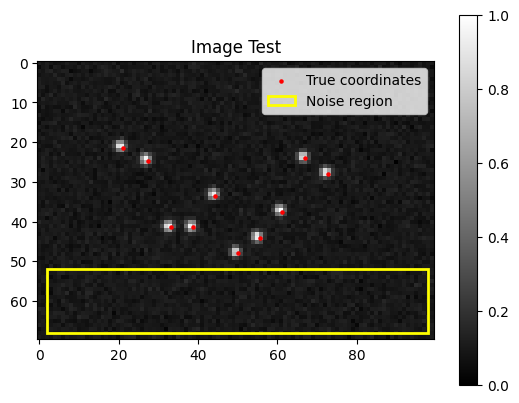

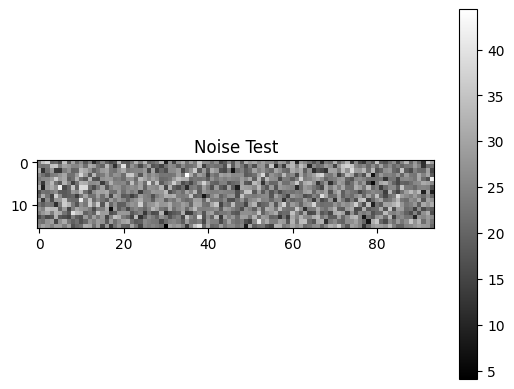

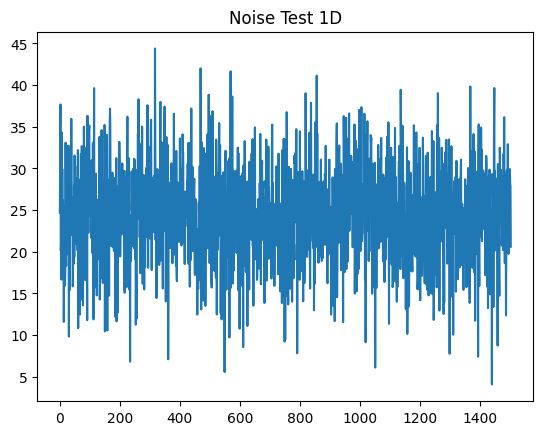

Fitted gaussian parameters, (amp, mean, stddev): [0.06849057 0.06242058 5.78419291]


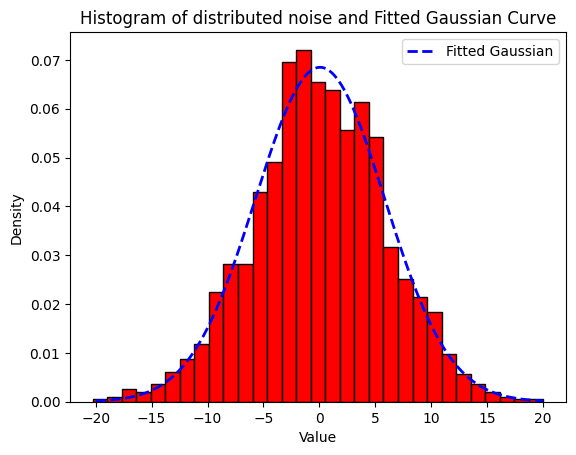

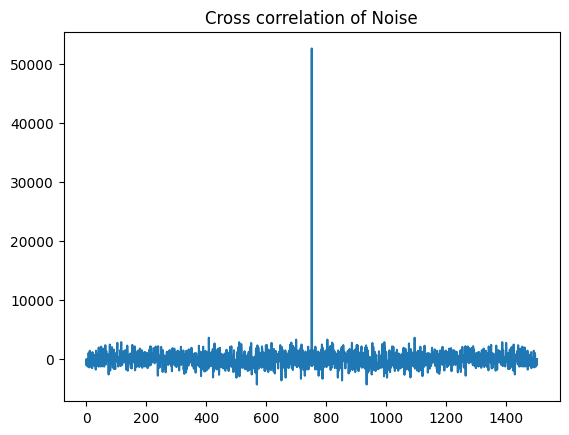

In [64]:
# Main

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.optimize import curve_fit
from scipy.signal import correlate
import scipy

def noise():

    # load and print .mat data

    CoordinatesTest = load_mat('CoordinatesTest.mat')
    # ImageFloue = load_mat_as_float_arrays('ImageFloue.mat')
    # ImagesPALM = load_mat_as_float_arrays('ImagesPALM.mat')
    ImageTest = load_mat('ImageTest.mat')

    CoordinatesTest_i = CoordinatesTest["i_molecules"]
    CoordinatesTest_j = CoordinatesTest["j_molecules"]
    ImageTest = ImageTest["ImageTest"]
    # print(ImageTest[0][1])
    
    # Find the minimum and maximum values in the array
    min_val = np.min(ImageTest)
    max_val = np.max(ImageTest)

    # Normalize the array to the range [0, 255]
    ImageTest = 255 * (ImageTest - min_val) / (max_val - min_val)
    # print(ImageTest[0][1])

    # # Convert to uint8 type (0 to 255) for image compatibility
    # ImageTest.astype(np.uint8)


    plt.imshow(ImageTest)
    plt.title("Image Test")
    plt.scatter(CoordinatesTest_j, CoordinatesTest_i, s=5, c="red", marker="o", label="True coordinates")
    rect = patches.Rectangle((2, 52), 96, 16, linewidth=2, edgecolor="yellow", facecolor='none',label="Noise region")
    plt.gca().add_patch(rect)
    plt.colorbar()
    plt.legend()
    plt.show()
    
    NoiseTest = ImageTest[52:68,2:96]
    plt.imshow(NoiseTest)
    plt.colorbar()
    plt.title("Noise Test")
    plt.show()

    plt.plot(NoiseTest.ravel())
    plt.title("Noise Test 1D")
    plt.show()

    # Histogram of noise distribution and gaussian fit

    # bins = np.linspace(-0.02, 0.02, 50)  # Define common bins for both histograms

    data = NoiseTest.ravel() - NoiseTest.ravel().mean()
    NoiseTest_hist, bin_edges = np.histogram(data, bins="auto", density=True)

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Compute bin centers

    plt.bar(bin_edges[:-1], NoiseTest_hist, width=np.diff(bin_edges), color="red", edgecolor="black", align="edge")
    # plt.hist(NoiseTest_hist, bins=bin_edges, density=True, alpha=0.6, color='blue', label='Histogram of noise distribution')
    # plt.show()

    # Step 3: Define the Gaussian function
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

    # Step 4: Fit the Gaussian curve to the histogram data
    # Provide initial estimates for amplitude, mean, and stddev
    popt, _ = curve_fit(gaussian, bin_centers, NoiseTest_hist, p0=[1, 0, 1])

    print(f"Fitted gaussian parameters, (amp, mean, stddev): {popt}")
    
    # popt_H0[1] += MC_H0_mean

    # Step 5: Plot the fitted Gaussian curve
    x_vals = np.linspace(-20, 20, 1000)
    plt.plot(x_vals, gaussian(x_vals, *popt), color='blue', linestyle='--', linewidth=2, label='Fitted Gaussian')

    # Additional plot settings
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.title(f"Histogram of distributed noise and Fitted Gaussian Curve")
    plt.show()

    ocor = correlate(data, data, mode='same', method="fft")
    plt.plot(ocor)
    plt.title("Cross correlation of Noise")
    plt.show()

    return popt

    

if __name__=="__main__":
    gaussian_param = noise()

### analysis of the CRLB
when the parameter a of the PSF is unknown, especially its variation with θ, according to the noise model (previously found)

### Expression of the ML estimator
and estimation of its bias and efficiency

### Optimal value of the PSF width w

## Implementation of the algorithm (2D)

### Algorithm for detection and rough estimation
of the position of single fluorophores in an image

### Expression and implementation of ML position estimator in 2D

In [ ]:
def r_ij(theta_x, theta_y, X, Y):
    """Computes the localization of a point according to the inte gration of a gaussian function of mean the true position. Needs sigma_r as global variable.

    Args:
        x (ndarray): position (integer)
        theta (scalar): true position

    Returns:
        list: localization, function of a pitch dx
    """
    
    res = 1 /4 * ( sp.special.erf((np.add(X, np.ones(X.shape)) - theta_x) /(sqrt(2) * sigma_r)) - sp.special.erf(((X) - theta) /(sqrt(2) * sigma_r)) ) * ( sp.special.erf((np.add(Y, np.ones(Y.shape)) - theta_y) /(sqrt(2) * sigma_r)) - sp.special.erf(((Y) - theta_y) /(sqrt(2) * sigma_r)) ) # (x+1) * dx & x * dx

    return res

def logLLH(theta_x, theta_y, noisy):
    """Computes the log-likelyhood of a noisy signal for a specific alpha.

    Args:
        alpha (scalar): decay rate of the determinist "clean signal""Données pour les TP-20240920"
        noisy (ndarray): noisy signal.
        x (list): time serie. 

    Returns:
        scalar: log-likelyhood for a specific decay rate and for a selected noisy signal.
    """

    I = noisy.shape[0]
    J = noisy.shape[1]

    X = np.asarray([j for j in range(J)])
    Y = np.asarray([i for i in range(I)])
    X, Y = np.meshgrid(X, Y)

    sigma = np.std(noisy) #scalar
    clean = r_ij(theta_x, theta_y, X, Y)

    sum = 0

    for i in range(I):
        sum += np.add( noisy[i], -clean[i])**2

    LLH = - I * J /2 * np.log(2 * pi * sigma_b**2) - 1 /2 /sigma_b**2 * sum

    return LLH

def fmaxLLH(noisy):
    """finds the minimum of the log-likelyhood function considered as a function of alpha.

    Args:
        alpha_0 (scalar): initial guess, comprised in [0,1]
        noisy (ndarray): noisy signal considered.
        
    Returns:
        scalar: alpha_0 such as the log-likelyhood is minimum.    
    """
    
    return  optimize.fmin(lambda a, b: -logLLH(a, b, noisy), disp=0)  # wrapper syntax, one could have used : optimize.fmin(logLLH, alpha_0, args = (noisy, x))

def PALM(image, count):

    
    plt.imshow(image)
    plt.title("Before analysis")
    plt.show()

    max = np.maximum(image)

    locations = []

    while max > 200:
        res = fmaxLLH(image)
        locations.append(res[0])
        image[loc[0]-4:loc[0]+4,loc[1]-4:loc[1]+4] = np.zeros(9,9)
        max = np.maximum(image)
    
    plt.imshow(image)
    plt.title("After analysis")
    plt.show()

    return locations, count



In [ ]:
def main(gaussian_param):

    # load .mat data: step 1 load dict
    CoordinatesTest = load_mat('CoordinatesTest.mat')
    # ImageFloue = load_mat_as_float_arrays('ImageFloue.mat')
    # ImagesPALM = load_mat_as_float_arrays('ImagesPALM.mat')
    ImageTest = load_mat('ImageTest.mat')

    # Step 2: load dict's values
    CoordinatesTest_i = CoordinatesTest["i_molecules"]
    CoordinatesTest_j = CoordinatesTest["j_molecules"]
    ImageTest = ImageTest["ImageTest"]

    # Work on ImageTest: grayscale
    # Find the minimum and maximum values in the array
    min_val = np.min(ImageTest)
    max_val = np.max(ImageTest)

    # Normalize the array to the range [0, 255]
    ImageTest = 255 * (ImageTest - min_val) / (max_val - min_val)


    # Start analysis
    a = gaussian_param[0]
    m = gaussian_param[1]
    stddev = gaussian_param[2]

    res = PALM(ImageTest, 1)
    print(res[0])



    # Plot results
    plt.imshow(ImageTest)
    plt.title("Image Test")
    plt.scatter(CoordinatesTest_j, CoordinatesTest_i, s=5, c="red", marker="o", label="True coordinates")
    rect = patches.Rectangle((2, 52), 96, 16, linewidth=2, edgecolor="yellow", facecolor='none',label="Noise region")
    plt.gca().add_patch(rect)
    plt.colorbar()
    plt.legend()
    plt.show()
    


    

if __name__=="__main__":
    gaussian_param = noise()
    main(gaussian_param)

### Application of the method to the proposed images and find the hidden pattern